In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv',index_col='Id')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv',index_col='Id')
submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv',
                        index_col='Id')

data = train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


### feature의 갯수가 상당히 많다, train은 80개, test는 79개이다

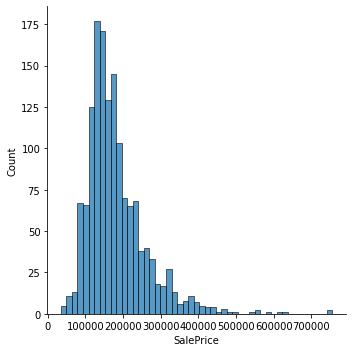

In [3]:
# 집값 분포
sns.displot(data['SalePrice'])

# SalePrice는 중심인 400000보다 왼쪽으로 치우쳐 있다. 데이터의 분포가 비대칭인 정도를 skewness라고 한다
# skewness의 꼬리가 오른쪽으로 길게있으면 right skewed 또는 positive skewed 라고 함
# 왼쪽으로 길면 left skewed 또는 negative skewed라고 함
# 한쪽으로 치우쳐 진 분포는 ML에서 잘 학습하지 못할 가능성이 있다
# 왜? 데이터가 sparse한 부분의 영향력이 미비하기 떄문에 right skewed를 해결하는 대표적인 방법 : square root, cube
# left skewed 를 해결하는 방법 : square, cube root, logarithmic

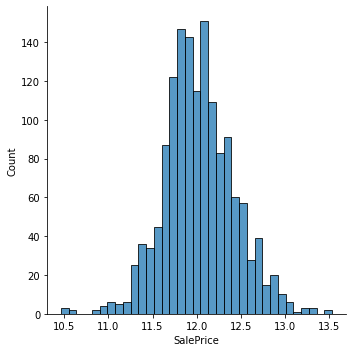

In [4]:
# 로그 취하기 -> 나중에 exp함수를 통해서 복원
sns.displot(np.log(data['SalePrice']+1))

<AxesSubplot:>

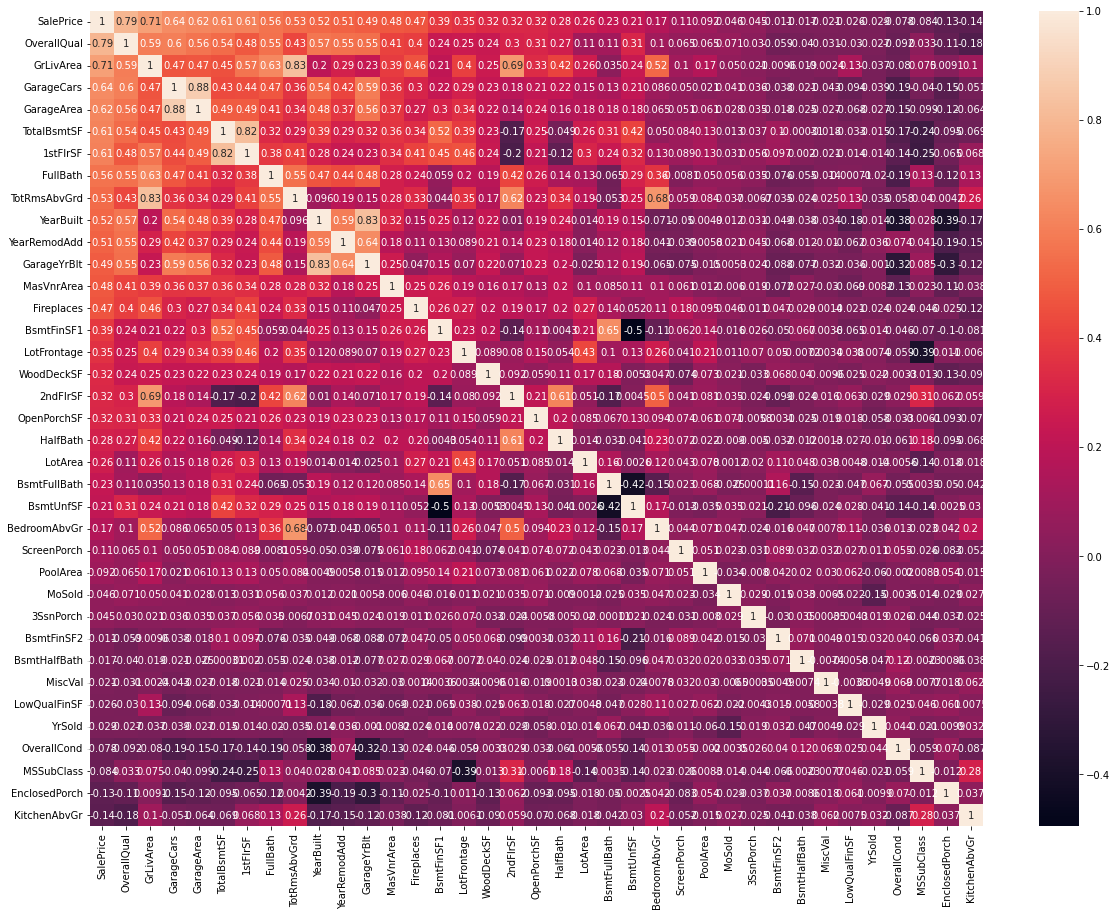

In [5]:
corr = data.corr()
top_corr = data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

# correlation은 변수간의 상관관계를 의미함
# overallQual이 가장 큰 상관관계를 가지는데, 이는 집의 재료나 마감상태가 집값에 큰 영향을 준다고 할 수 있다


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

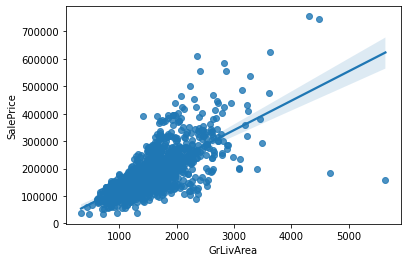

In [6]:
sns.regplot(data['GrLivArea'],data['SalePrice'])

# 두번째로 상관정도가 큰 GrLivArea(실평수)도 아래와 같다
# 분포와 맞지 않는 포인트들이 있는데, 이는 다른 요소가 작용하여 집값을 떨어뜨렸을 가능성이 있지만, 여기서 고려하지 않음.

In [7]:
# 노이즈 값 삭제
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<600000)].index)

In [8]:
y_train = train['SalePrice']
train = train[list(test)]
all_data = pd.concat((train,test), axis=0)
print(all_data.shape)
y_train = np.log(y_train+1)

(2917, 79)


In [9]:
# 결측치 확인
cols = list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum()) == 0:
        cols.remove(col)
    else:
        pass
print(len(cols))
print(cols)

# 결측치가 하나라도 있는 feature는 34개이다.
all_data['BsmtHalfBath']

34
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


Id
1       0.0
2       1.0
3       0.0
4       0.0
5       0.0
       ... 
2915    0.0
2916    0.0
2917    0.0
2918    1.0
2919    0.0
Name: BsmtHalfBath, Length: 2917, dtype: float64

In [10]:
# 결측치 처리
# 1. 집에 해당 시설물이 없는 경우, 결측치를 None으로 채운다. ( 1번 col은 전부 시설물 관련 범주형 features )
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',):
    all_data[col] = all_data[col].fillna('None')
    
# 2. 집에 해당 시설물이 없는 경우, 결측치를 None으로 채운다. ( 1번 col은 전부 시설물 관련 수치형 features )
for col in ('GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','LotFrontage','MasVnrArea','BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# 3. 그외의 경우는 최빈값으로 채워준다.
for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional','Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data: {all_data.isnull().sum().sum()}")

Total count of missing values in all_data: 0


In [11]:
cols = list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum()) == 0:
        cols.remove(col)
    else:
        pass
print(len(cols))

# 결측치 다 채움!

0


<AxesSubplot:ylabel='SalePrice'>

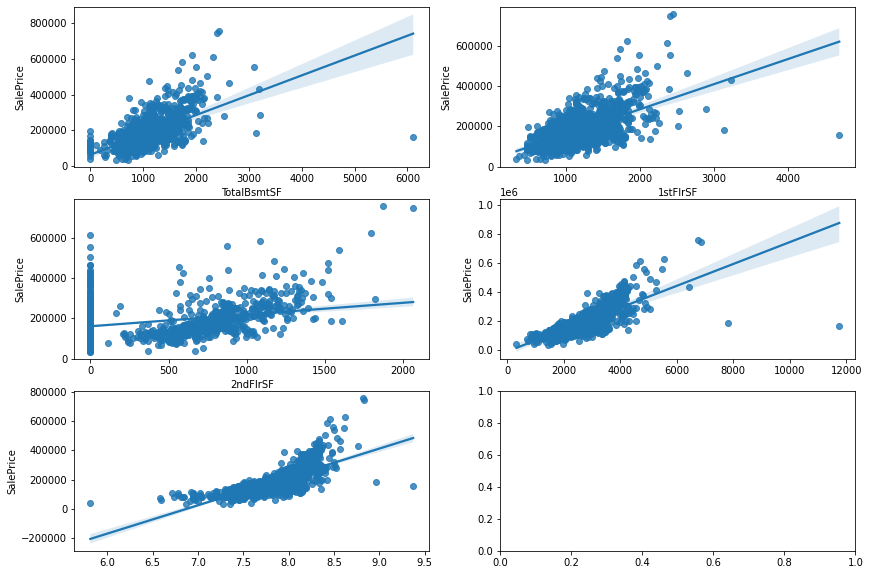

In [12]:
figure, ((ax1, ax2), (ax3, ax4), (ax5,_)) = plt.subplots(nrows=3,ncols=2)
figure.set_size_inches(14,10)
# 지하실 면적
sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1)
# 1층 면적
sns.regplot(data['1stFlrSF'], data['SalePrice'], ax=ax2)
# 2층 면적
sns.regplot(data['2ndFlrSF'], data['SalePrice'], ax=ax3)
# 지하실 + 1층면적 + 2층면적 = 전체면적
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], data['SalePrice'], ax=ax4)
sns.regplot(np.log(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] +1),data['SalePrice'], ax=ax5)

# 지하실, 1층, 2층 면적을 합한 '총 면적' 변수를 추가함
# log를 씌워준게 더 좋은 데이터일지 그냥 데이터가 더 좋은 데이터일지는 확인해봐야하나, 이 총 면적 데이터는 유의미한 결과일 것으로 예상

In [13]:
# 전체면적에 로그를 씌어준 컬럼 추가
all_data['TotalSF'] = np.log(all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
# 2층이 없는 컬럼 추가
all_data['No2ndFlr'] = (all_data['2ndFlrSF']==0)
# 지하실이 없는 컬럼 추가
all_data['NoBsmt'] = (all_data['TotalBsmtSF']==0)

<AxesSubplot:ylabel='SalePrice'>

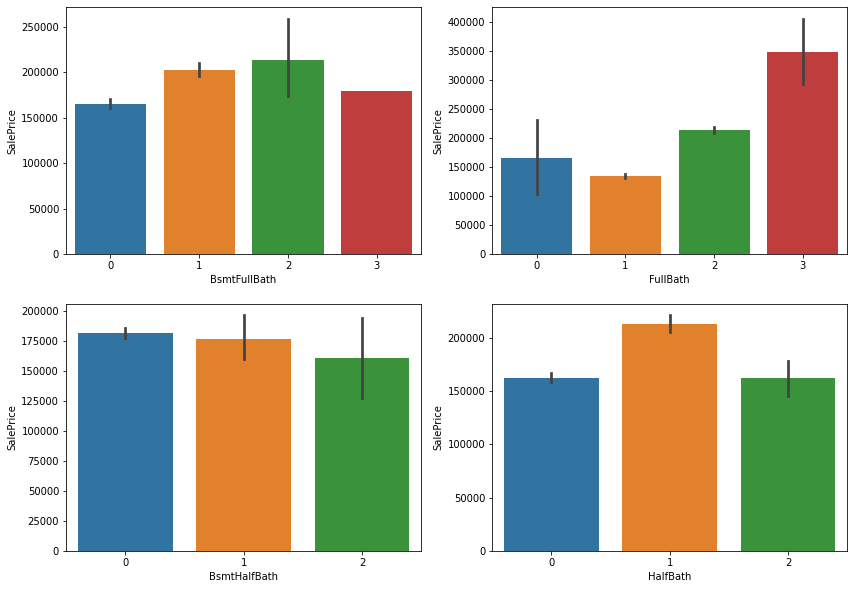

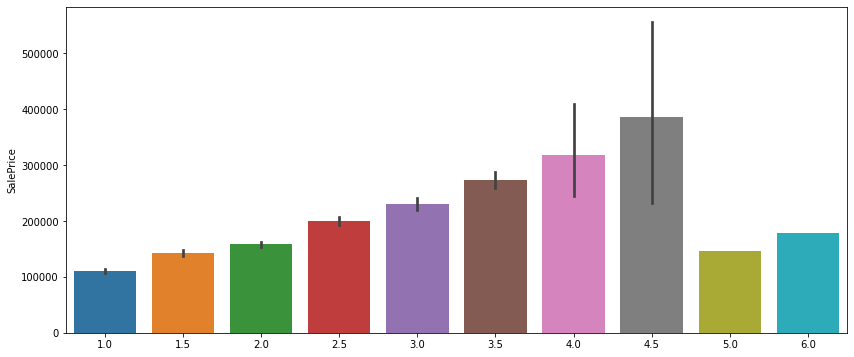

In [14]:
figure,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
# 지하실 full bath
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax=ax1)
sns.barplot(data['FullBath'], data['SalePrice'], ax=ax2)
# 지하실 half bath
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax=ax3)
sns.barplot(data['HalfBath'], data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(14, 6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2),
           data['SalePrice'], ax=ax5)

# 화징실이 많으면 집이 크고 방이 많다는 의미이기도 하니깐
# 총 bathroom 갯수를 구한 표, 5와 6은 편차가 없으므로 값이 하나라고 볼 수 있음 -> 지워도 무방
# 검은 바가 분산을 의미, 5와 6은 검은 바가 존재 X : 데이터가 하나씩 있다는 뜻 : 노이즈라고 판단
# HalfBath는 반쪽짜리 화장실이기에? 1/2을 해주었다..

In [15]:
all_data['TotalBath'] = data['BsmtFullBath']+data['FullBath']+(data['BsmtHalfBath']/2)+(data['HalfBath']/2)

In [16]:
# 결측치 하나가 제거
cols = list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum()) == 0:
        cols.remove(col)
    else:
        pass
print(len(cols))
print(cols)

for col in cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

1
['TotalBath']


In [17]:
all_data['TotalBath'] = all_data['TotalBath'].fillna(all_data['TotalBath'].mode()[0])

In [18]:
cols = list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum() == 0): 
        cols.remove(col)
    else:
        pass
print(len(cols))
print(cols)

0
[]


<AxesSubplot:ylabel='SalePrice'>

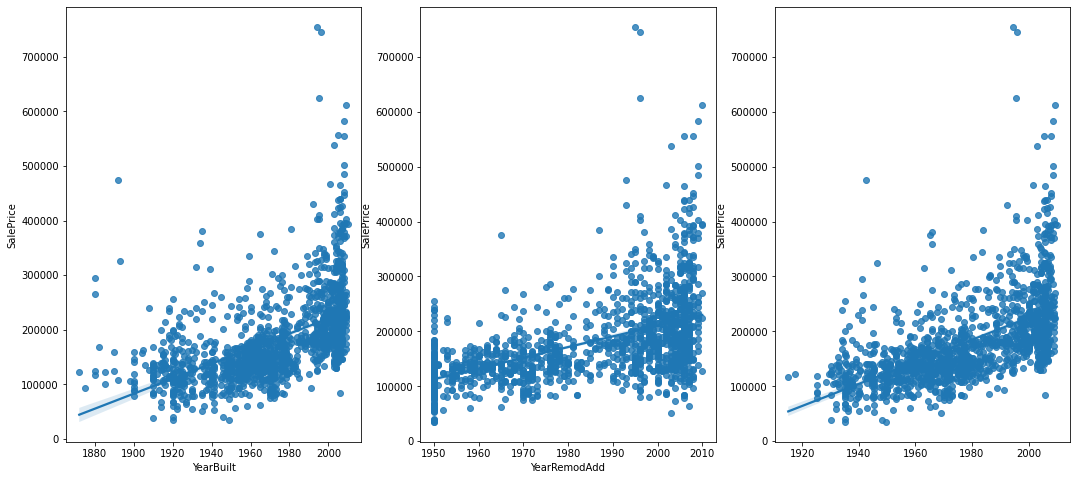

In [19]:
# 건축년도와 리모델링년도
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'], data['SalePrice'], ax=ax1)
sns.regplot(data['YearRemodAdd'], data['SalePrice'], ax=ax2)
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2, data['SalePrice'],ax=ax3) # '/2' for graph scaling

# 두 개가 비슷한 분포를 보인다
# -> 건축년도와 리모델링년도도 합치는게 나아보인다.

In [20]:
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

In [21]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

# MS sub class는 빌딩넘버이므로 수치적으로 의미가 있다고 하기 힘들다
# 판매 년월도 일단은 문자열 처리를 한다
# 그러나 이건 테스트 해볼 것!

In [22]:
# 지하실 옵션 전처리 - 각 시설물 마다 점수를 부과한다.
Basement=['BsmtCond','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtQual',
         'BsmtUnfSF','BsmtFullBath','BsmtHalfBath','TotalBsmtSF']
Bsmt = all_data[Basement]

Bsmt = Bsmt.replace(to_replace='Po', value=1)
Bsmt = Bsmt.replace(to_replace='Fa', value=2)
Bsmt = Bsmt.replace(to_replace='TA', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)
Bsmt = Bsmt.replace(to_replace='Ex', value=5)
Bsmt = Bsmt.replace(to_replace='None', value=0.5)

Bsmt = Bsmt.replace(to_replace='No', value=1)
Bsmt = Bsmt.replace(to_replace='Mn', value=2)
Bsmt = Bsmt.replace(to_replace='Av', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)

Bsmt = Bsmt.replace(to_replace='Unf', value=1)
Bsmt = Bsmt.replace(to_replace='LwQ', value=2)
Bsmt = Bsmt.replace(to_replace='Rec', value=3)
Bsmt = Bsmt.replace(to_replace='BLQ', value=4)
Bsmt = Bsmt.replace(to_replace='ALQ', value=5)
Bsmt = Bsmt.replace(to_replace='GLQ', value=6)

In [23]:
Bsmt['BsmtScore'] = Bsmt['BsmtQual'] * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore'] = Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore'] = Bsmt['BsmtFin']
all_data['BsmtDNF'] = (all_data['BsmtFinScore'] == 0 )

# 지하실에 대한 종합점수를 만들어줌

In [24]:
lot = ['LotFrontage', 'LotArea', 'LotConfig', 'LotShape']
Lot = all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage']*Lot['LotArea'])+1)
all_data['LotScore'] = Lot['LotScore']

# 토지면적과 모양, 접근성 등등을 고려해서 점수로 만들어 토지점수로 저장

In [25]:
garage = ['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage = all_data[garage]
all_data['NoGarage'] = (all_data['GarageArea']==0)

Garage = Garage.replace(to_replace='Po', value=1)
Garage = Garage.replace(to_replace='Fa', value=2)
Garage = Garage.replace(to_replace='TA', value=3)
Garage = Garage.replace(to_replace='Gd', value=4)
Garage = Garage.replace(to_replace='Ex', value=5)
Garage = Garage.replace(to_replace='None', value=0.5)

Garage = Garage.replace(to_replace='Unf', value=1)
Garage = Garage.replace(to_replace='RFn', value=2)
Garage = Garage.replace(to_replace='Fin', value=3)

Garage = Garage.replace(to_replace='CarPort', value=1)
Garage = Garage.replace(to_replace='Basment', value=2)
Garage = Garage.replace(to_replace='Detchd', value=3)
Garage = Garage.replace(to_replace='2Types', value=4)
Garage = Garage.replace(to_replace='Basement', value=5)
Garage = Garage.replace(to_replace='Attchd', value=6)
Garage = Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea'])*(Garage['GarageCars'])*(Garage['GarageFinish'])*(Garage['GarageQual'])*(Garage['GarageCond'])*(Garage['GarageType'])*(Garage['GarageYrBlt'])
all_data['GarageScore'] = Garage['GarageScore']

# 차고에 대해서도 같은 방법으로 진행

In [26]:
all_data = all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

# 비정상으로 하나의 값만 많은 변수들 삭제

In [27]:
all_data = all_data.drop(columns=['PoolArea','PoolQC'])

# 수영장관련 컬럼들도 의미 X

In [28]:
all_data = all_data.drop(columns=['MiscVal','MiscFeature']) 

# 테니스장 관련 컬럼들도 의미 X

In [29]:
all_data['NoLowQual'] = (all_data['LowQualFinSF']==0)
all_data['NoOpenPorch'] = (all_data['OpenPorchSF']==0)
all_data['NoWoodDeck'] = (all_data['WoodDeckSF']==0)

# 채워진 결측치(0으로 셋된 경우는 따로 분리해둠)

In [30]:
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) != 0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col],prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

# 카테고리 변수는 원핫인코딩 처리

(2917, 309)


In [31]:
numeric = all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:    # 왼쪽으로 치우쳐져 있음을 판단
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been transformed")
    print(all_data.shape)
    
log_transform(list(numeric))

# 수치형 변수는 right skewed가 발생하는 경우 log처리해줌!

255 features had been transformed
(2917, 309)


In [32]:
cols = list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum()) ==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

0


In [33]:
print(train.shape, test.shape)
X_train = all_data[:len(train)]
X_test = all_data[len(train):]
print(X_train.shape, X_test.shape)

(1458, 79) (1459, 79)
(1458, 309) (1459, 309)


In [34]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

model_Lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.000326, random_state=18))
model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))
model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                        max_features='sqrt',min_samples_leaf=1,min_samples_split=10,
                                        loss='huber',random_state=18)
model_XGB=XGBRegressor(colsameple_bylevel=0.9229733609038979, colsample_bynode=0.21481791874780318,
                      colsamle_bytree=0.60796431829, gamma=0.8989889854961725, learning_rate=0.009192310189734834,
                      max_depth=3, n_estimators=3602, reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13,
                      seed=18,subsample=0.8381904293270576,verbosity=0)

In [35]:
model_Lasso.fit(X_train,y_train)
Lasso_predictions=model_Lasso.predict(X_test)
train_Lasso=model_Lasso.predict(X_train)

model_ENet.fit(X_train,y_train)
ENet_predictions=model_ENet.predict(X_test)
train_ENet=model_ENet.predict(X_train)

model_XGB.fit(X_train,y_train)
XGB_predictions=model_XGB.predict(X_test)
train_XGB=model_XGB.predict(X_train)

model_GBoost.fit(X_train,y_train)
GBoost_predictions=model_GBoost.predict(X_test)
train_GBoost=model_GBoost.predict(X_train)

log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost)/4
# log_train_predictions = (train_ENet + train_Lasso + train_GBoost)/3
train_score = np.sqrt(mean_squared_error(y_train, log_train_predictions))
print(f"Scoring with train data : {train_score}")

log_predictions = (Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions)/4
# log_predictions = (ENet_predictions + Lasso_predictions + GBoost_predictions)/3
predictions = np.exp(log_predictions)-1
submission['SalePrice'] = predictions

Scoring with train data : 0.07804387405757214


In [36]:
submission.to_csv('sample_submission.csv',index=False)